In [1]:
import os

import matplotlib.pyplot as plt

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics


def run_simulation(scheduler_name, fs_config_path, jobs_count):
    """运行模拟并返回结果"""
    current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
    base_dir = os.path.dirname(current_dir)


    config = SimulatorConfig(
        cluster_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/cluster_config.json"),
        fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/"+fs_config_path),
        scheduler_name=scheduler_name,
        task_config_path=os.path.join(base_dir, f"cedtrainscheduler/cases/task/case_{jobs_count}_tasks.csv"),
        output_path=os.path.join(base_dir, "examples/outputs"),
    )

    simulator = Simulator(config)
    results = simulator.simulation()
    return results


# 假设 results_dict_light 和 results_dict_heavy 是两个模拟器的结果字典
# 运行不同调度器的模拟
schedulers = ["k8s-data", "k8s", "sjf-data", "sjf", "ced"]
jobs_count_list = [2000]
results_dict_light: dict[int, dict[str, Metrics]] = {}
results_dict_heavy: dict[int, dict[str, Metrics]] = {}

for jobs_count in jobs_count_list:
    results_dict_light[jobs_count] = {}
    results_dict_heavy[jobs_count] = {}
    for scheduler in schedulers:
        # 使用轻量版配置运行模拟
        results_light = run_simulation(scheduler, fs_config_path='fs_config_light.json', jobs_count=jobs_count)
        results_dict_light[jobs_count][scheduler] = results_light
        print(results_light)

        # 使用重版配置运行模拟
        results_heavy = run_simulation(scheduler, fs_config_path='fs_config_heavy.json', jobs_count=jobs_count)
        results_dict_heavy[jobs_count][scheduler] = results_heavy
        print(results_heavy)


Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=2000, total_runtime=1293501.174930799, avg_queue_time=277600.26808806346, avg_running_time=293439.6550880632, avg_execution_time=15839.387, cloud_count=798, edge_count=841, terminal_count=361)
Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=2000, total_runtime=1698711.988028156, avg_queue_time=409045.22710787255, avg_running_time=424129.24960787286, avg_execution_time=15084.0225, cloud_count=1093, edge_count=423, terminal_count=484)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=2000, total_runtime=2454077.10527259, avg_queue_time=334858.6241598705, avg_running_time=350588.71515987074, avg_execution_time=15730.091, cloud_count=651, edge_count=770, terminal_count=579)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=2000, total_runtime=2807970.467584413, avg_queue_time=430033.3623442376, avg_running_time=445764.5823442378, avg_execution_time=15731.22, cloud_count=651, edge_count=767, te

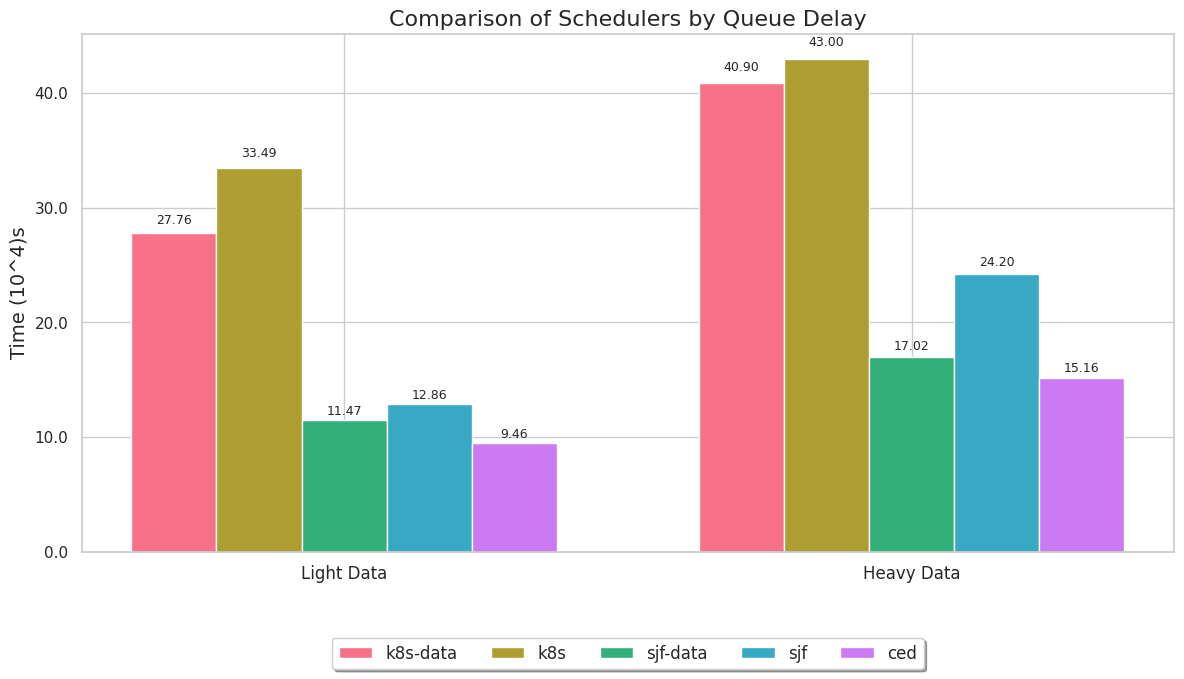

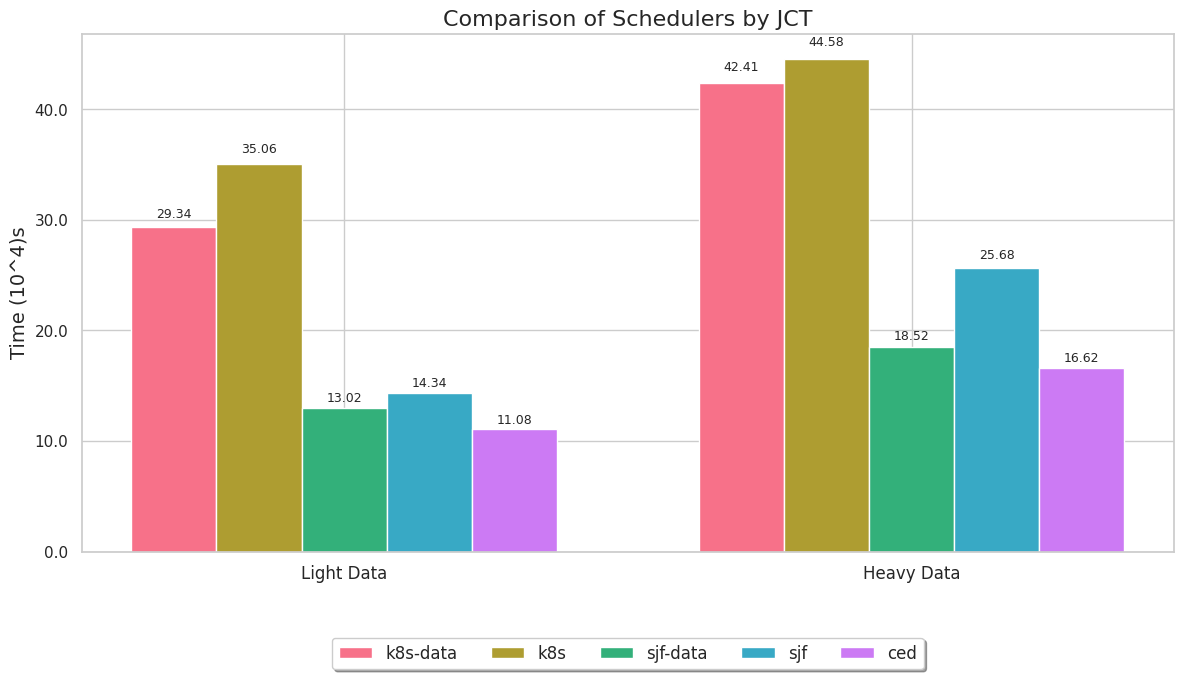

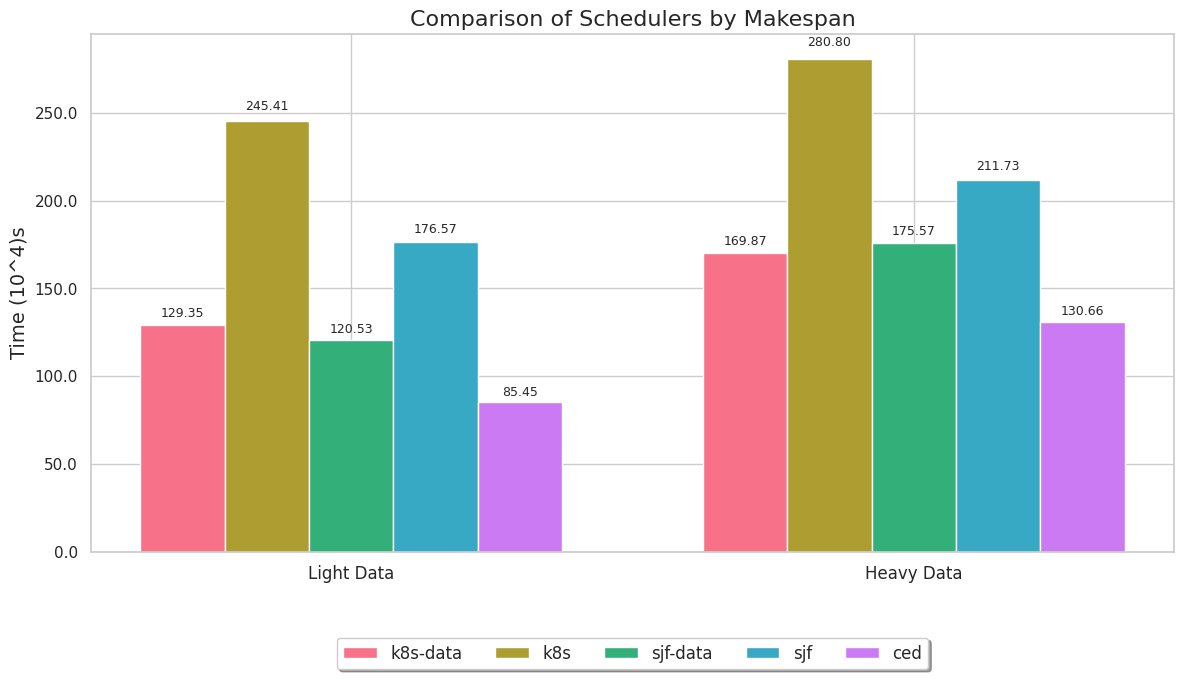

In [2]:
def plot_results(results_dict_light, results_dict_heavy):
    """绘制结果图"""
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter

    # 使用 seaborn 风格
    sns.set(style="whitegrid")

    # 指标名称
    metrics_names = ['Queue Delay', 'JCT', 'Makespan']
    width = 0.15  # 调整条形图的宽度
    x_positions = [0, 1]  # 0 for light-data, 1 for heavy-data

    # 自定义颜色，为每个调度器分配不同的颜色
    colors = sns.color_palette("husl", len(results_dict_light))

    # 分别为每个指标创建一个图形窗口
    for metric_name in metrics_names:
        fig, ax = plt.subplots(figsize=(12, 7))  # 增加图表大小，留出更多空间

        for i, (scheduler_name, metrics_light) in enumerate(results_dict_light.items()):
            metrics_heavy = results_dict_heavy[scheduler_name]

            if metric_name == 'Queue Delay':
                value_light = metrics_light.avg_queue_time
                value_heavy = metrics_heavy.avg_queue_time
            elif metric_name == 'JCT':
                value_light = metrics_light.avg_running_time
                value_heavy = metrics_heavy.avg_running_time
            elif metric_name == 'Makespan':
                value_light = metrics_light.total_runtime
                value_heavy = metrics_heavy.total_runtime

            # 绘制轻量版和重版的条形图
            ax.bar(x_positions[0] + i * width - (len(results_dict_light) - 1) * width / 2, value_light, width, color=colors[i], label=scheduler_name)
            ax.bar(x_positions[1] + i * width - (len(results_dict_light) - 1) * width / 2, value_heavy, width, color=colors[i])

        ax.set_title(f'Comparison of Schedulers by {metric_name}', fontsize=16)
        ax.set_ylabel('Time (10^4)s', fontsize=14)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(['Light Data', 'Heavy Data'], fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y / 1e4:.1f}'))

        # 将图例放置在图表下方，避免遮挡数据
        ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                  fancybox=True, shadow=True, ncol=len(results_dict_light))

        # 添加数据标签显示具体值
        for i, (scheduler_name, metrics_light) in enumerate(results_dict_light.items()):
            metrics_heavy = results_dict_heavy[scheduler_name]

            if metric_name == 'Queue Delay':
                value_light = metrics_light.avg_queue_time
                value_heavy = metrics_heavy.avg_queue_time
            elif metric_name == 'JCT':
                value_light = metrics_light.avg_running_time
                value_heavy = metrics_heavy.avg_running_time
            elif metric_name == 'Makespan':
                value_light = metrics_light.total_runtime
                value_heavy = metrics_heavy.total_runtime

            # 在条形图上方显示数值
            ax.text(x_positions[0] + i * width - (len(results_dict_light) - 1) * width / 2,
                    value_light * 1.02,
                    f'{value_light/1e4:.2f}',
                    ha='center', va='bottom', fontsize=9)

            ax.text(x_positions[1] + i * width - (len(results_dict_light) - 1) * width / 2,
                    value_heavy * 1.02,
                    f'{value_heavy/1e4:.2f}',
                    ha='center', va='bottom', fontsize=9)

        # 调整布局（增加底部空间以容纳图例）
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)  # 调整下边距，为图例留出空间
        plt.show()


# 一次绘制特定任务数量的图表
def plot_specific_jobs(job_count):
    """绘制特定任务数量的结果比较图"""
    light_results = {scheduler: results_dict_light[job_count][scheduler] for scheduler in schedulers}
    heavy_results = {scheduler: results_dict_heavy[job_count][scheduler] for scheduler in schedulers}
    plot_results(light_results, heavy_results)


plot_specific_jobs(2000)

In [3]:
# 计算 ced 的 JCT 降低百分比相对于其他调度器
def calculate_ced_jct_reduction(results_dict_light, results_dict_heavy):
    jct_reduction_light = {}
    jct_reduction_heavy = {}

    for scheduler in results_dict_light.keys():
        if scheduler == 'ced':
            continue

        jct_ced_light = results_dict_light['ced'].avg_running_time
        jct_ced_heavy = results_dict_heavy['ced'].avg_running_time

        jct_light = results_dict_light[scheduler].avg_running_time
        jct_heavy = results_dict_heavy[scheduler].avg_running_time

        # 计算 ced 相对于其他调度器的降低百分比
        reduction_light = ((jct_light - jct_ced_light) / jct_light) * 100
        reduction_heavy = ((jct_heavy - jct_ced_heavy) / jct_heavy) * 100

        jct_reduction_light[scheduler] = reduction_light
        jct_reduction_heavy[scheduler] = reduction_heavy

    return jct_reduction_light, jct_reduction_heavy

selected_results_dict_light = results_dict_light[2000]
selected_results_dict_heavy = results_dict_heavy[2000]
# 获取 ced 的 JCT 降低百分比
jct_reduction_light, jct_reduction_heavy = calculate_ced_jct_reduction(selected_results_dict_light, selected_results_dict_heavy)

# 输出结果
print("ced 的 JCT 降低百分比相对于其他调度器:")
for scheduler in jct_reduction_light.keys():
    print(f"{scheduler}: Light 情况下降低了 {jct_reduction_light[scheduler]:.2f}%, Heavy 情况下降低了 {jct_reduction_heavy[scheduler]:.2f}%")


# 计算 ced 的 Makespan 降低百分比相对于其他调度器
def calculate_ced_makespan_reduction(results_dict_light, results_dict_heavy):
    makespan_reduction_light = {}
    makespan_reduction_heavy = {}

    for scheduler in results_dict_light.keys():
        if scheduler == 'ced':
            continue

        makespan_ced_light = results_dict_light['ced'].total_runtime
        makespan_ced_heavy = results_dict_heavy['ced'].total_runtime

        makespan_light = results_dict_light[scheduler].total_runtime
        makespan_heavy = results_dict_heavy[scheduler].total_runtime

        # 计算 ced 相对于其他调度器的降低百分比
        reduction_light = ((makespan_light - makespan_ced_light) / makespan_light) * 100
        reduction_heavy = ((makespan_heavy - makespan_ced_heavy) / makespan_heavy) * 100

        makespan_reduction_light[scheduler] = reduction_light
        makespan_reduction_heavy[scheduler] = reduction_heavy

    return makespan_reduction_light, makespan_reduction_heavy

# 获取 ced 的 Makespan 降低百分比
makespan_reduction_light, makespan_reduction_heavy = calculate_ced_makespan_reduction(selected_results_dict_light, selected_results_dict_heavy)

# 输出结果  
print("ced 的 Makespan 降低百分比相对于其他调度器:")
for scheduler in makespan_reduction_light.keys():
    print(f"{scheduler}: Light 情况下降低了 {makespan_reduction_light[scheduler]:.2f}%, Heavy 情况下降低了 {makespan_reduction_heavy[scheduler]:.2f}%")

ced 的 JCT 降低百分比相对于其他调度器:
k8s-data: Light 情况下降低了 62.26%, Heavy 情况下降低了 60.82%
k8s: Light 情况下降低了 68.41%, Heavy 情况下降低了 62.72%
sjf-data: Light 情况下降低了 14.95%, Heavy 情况下降低了 10.25%
sjf: Light 情况下降低了 22.75%, Heavy 情况下降低了 35.30%
ced 的 Makespan 降低百分比相对于其他调度器:
k8s-data: Light 情况下降低了 33.94%, Heavy 情况下降低了 23.09%
k8s: Light 情况下降低了 65.18%, Heavy 情况下降低了 53.47%
sjf-data: Light 情况下降低了 29.11%, Heavy 情况下降低了 25.58%
sjf: Light 情况下降低了 51.61%, Heavy 情况下降低了 38.29%
